In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import seaborn as sns

import sys
sys.path.append('../src')
import mevpy as mev

matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.style.use('seaborn-v0_8')

## Data Processing

The padova dataset is used. 
Precipitation: 1725-2022
T: 1774-1997

(Marani, M. and Zanetti, S., 2015. Long‐term oscillations in rainfall extremes in a 268 year daily time series. Water Resources Research, 51(1), pp.639-647.)


In [2]:
# PRCP in [mm]

ts = pd.read_csv('../data/padova/PADOVA_1725_2022_PRCPdaily_reorganize.csv')
ts['Date'] = pd.to_datetime((ts.YY*10000+ts.MM*100+ts.DD).apply(str),format='%Y%m%d')
ts['DATE'] = (ts.YY*10000+ts.MM*100+ts.DD).apply(str)
ts = ts.drop(['DD', 'MM'], axis=1)[['DATE', 'Date', 'YY', 'PRCP']].rename(columns={'YY':'YEAR'})
ts.head()

,DATE,Date,YEAR,PRCP
0,17250101,1725-01-01,1725,0.0
1,17250102,1725-01-02,1725,0.0
2,17250103,1725-01-03,1725,0.0
3,17250104,1725-01-04,1725,0.0
4,17250105,1725-01-05,1725,0.0


In [3]:
study_periods = [('1725-01-01','1764-12-31'),('1768-01-01','1807-12-31'),('1841-01-01','1880-12-31'),('1887-01-01','2021-12-31')]
ts1 = ts[(ts['Date'] >= study_periods[0][0]) & (ts['Date'] <= study_periods[0][1])]
ts2 = ts[(ts['Date'] >= study_periods[1][0]) & (ts['Date'] <= study_periods[1][1])]
ts3 = ts[(ts['Date'] >= study_periods[2][0]) & (ts['Date'] <= study_periods[2][1])]
ts4 = ts[(ts['Date'] >= study_periods[3][0]) & (ts['Date'] <= study_periods[3][1])]
ts = pd.concat([ts1, ts2, ts3, ts4], ignore_index=True)
ts.head()

,DATE,Date,YEAR,PRCP
0,17250101,1725-01-01,1725,0.0
1,17250102,1725-01-02,1725,0.0
2,17250103,1725-01-03,1725,0.0
3,17250104,1725-01-04,1725,0.0
4,17250105,1725-01-05,1725,0.0


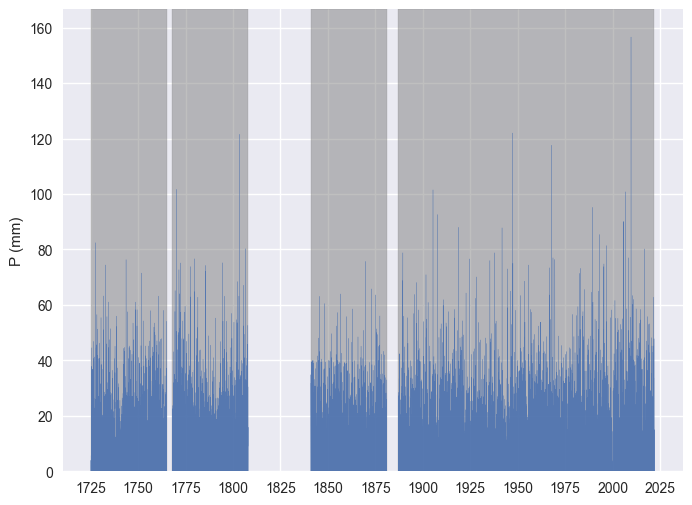

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting precipitation
ax.plot(ts['Date'], ts['PRCP'], label='P (mm)', alpha=0.9, linewidth=0.2)

# Styling the axis
ax.set_ylim([ts['PRCP'].min(), ts['PRCP'].max()+10])
ax.set_ylabel('P (mm)')


ax.xaxis.set_major_locator(mdates.YearLocator(25))
ax.xaxis.set_minor_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=0, horizontalalignment='center')

ax.grid(True)

# Study period (Marani, 2015)
plt.axvspan(np.datetime64('1725-01-01'), np.datetime64('1764-12-31'), color='grey', alpha=0.5)
plt.axvspan(np.datetime64('1768-01-01'), np.datetime64('1807-12-31'), color='grey', alpha=0.5)
plt.axvspan(np.datetime64('1841-01-01'), np.datetime64('1880-12-31'), color='grey', alpha=0.5)
plt.axvspan(np.datetime64('1887-01-01'), np.datetime64('2021-12-31'), color='grey', alpha=0.5)

## Daily Rainfall Survival Probability $\Psi(x)$ for the period 1841-2006

In [5]:
def surv_prob(startYear, endYear):
    P_sorted = np.sort(ts[(ts['Date'] < str(endYear)+'-12-31') & (ts['DATE'] > str(startYear)+'-01-01') & ts['PRCP'] > 0]['PRCP'].values)
    N = len(P_sorted)
    rank = np.arange(N) + 1
    surv_prob_ = 1 - rank / (N+1)
    return (P_sorted, surv_prob_)

yearly_surv_probs_ = []
startYear = 1841
endYear = 2006

for i in range(startYear, endYear + 1):
    yearly_surv_probs_.append(surv_prob(i, i))

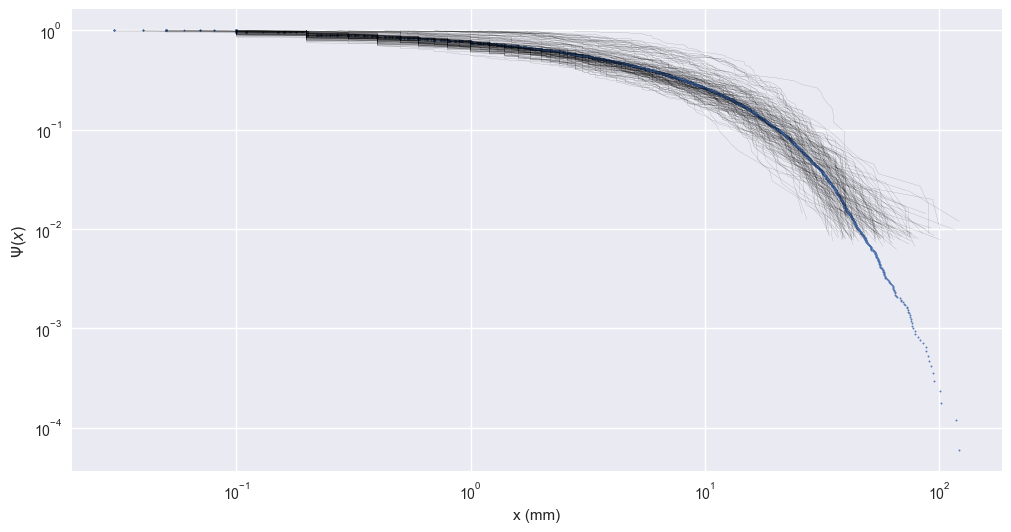

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('x (mm)')
ax.set_ylabel(r'$\Psi(x)$')

# Daily Rainfall Survival Probability for each single year
ax.scatter(*surv_prob(1841, 2006), label='1841 - 2006', alpha=0.9, s=1)
for a in yearly_surv_probs_:
    ax.plot(*a, c='k', alpha=0.6, linewidth=0.1)


In [17]:
ts, ny2, ny1 = mev.remove_missing_years(ts, 36)

years = pd.Series.unique(ts['YEAR'])
df = pd.DataFrame(columns=['YEAR', 'AM', 'AM_DATE', 'n', 'c', 'w'])

for year in range(ts['YEAR'].min(), ts['YEAR'].max()+1):
    yearly_df = ts.loc[ts['Date'].dt.year==year]
    yearly_df = yearly_df.reset_index()
    yearly_prcp = yearly_df['PRCP'].values
    if yearly_prcp.any(): # Check if sample is not empty
        am = yearly_df.iloc[yearly_df['PRCP'].idxmax()]
        # TODO: Decluster and get event temperature
        n, c, w = mev.wei_fit(yearly_prcp[yearly_prcp > 0], how = 'ml')
        df.loc[len(df)] = {'YEAR':year, 'AM':am['PRCP'], 'AM_DATE':am['Date'], 'n':n, 'c':c, 'w':w}
    else:
        df.loc[len(df)] = {'YEAR':year, 'AM':np.NaN, 'AM_DATE':np.NaN, 'n':np.NaN, 'c':np.NaN, 'w':np.NaN}
    

df

,YEAR,AM,AM_DATE,n,c,w
0,1725,44.5516,1725-08-15,91.0,7.455462,0.819358
1,1726,46.8630,1726-04-30,81.0,7.048802,0.846049
2,1727,82.4484,1727-09-03,119.0,9.101301,0.875386
3,1728,56.5150,1728-04-08,121.0,10.057821,0.820155
4,1729,46.2280,1729-10-27,101.0,8.146239,0.803510
...,...,...,...,...,...,...
292,2017,47.0000,2017-11-13,98.0,5.606962,0.770565
293,2018,55.8000,2018-07-22,125.0,6.603958,0.712971
294,2019,53.2000,2019-04-23,123.0,6.394094,0.742619
295,2020,48.2000,2020-06-04,120.0,3.835938,0.673316


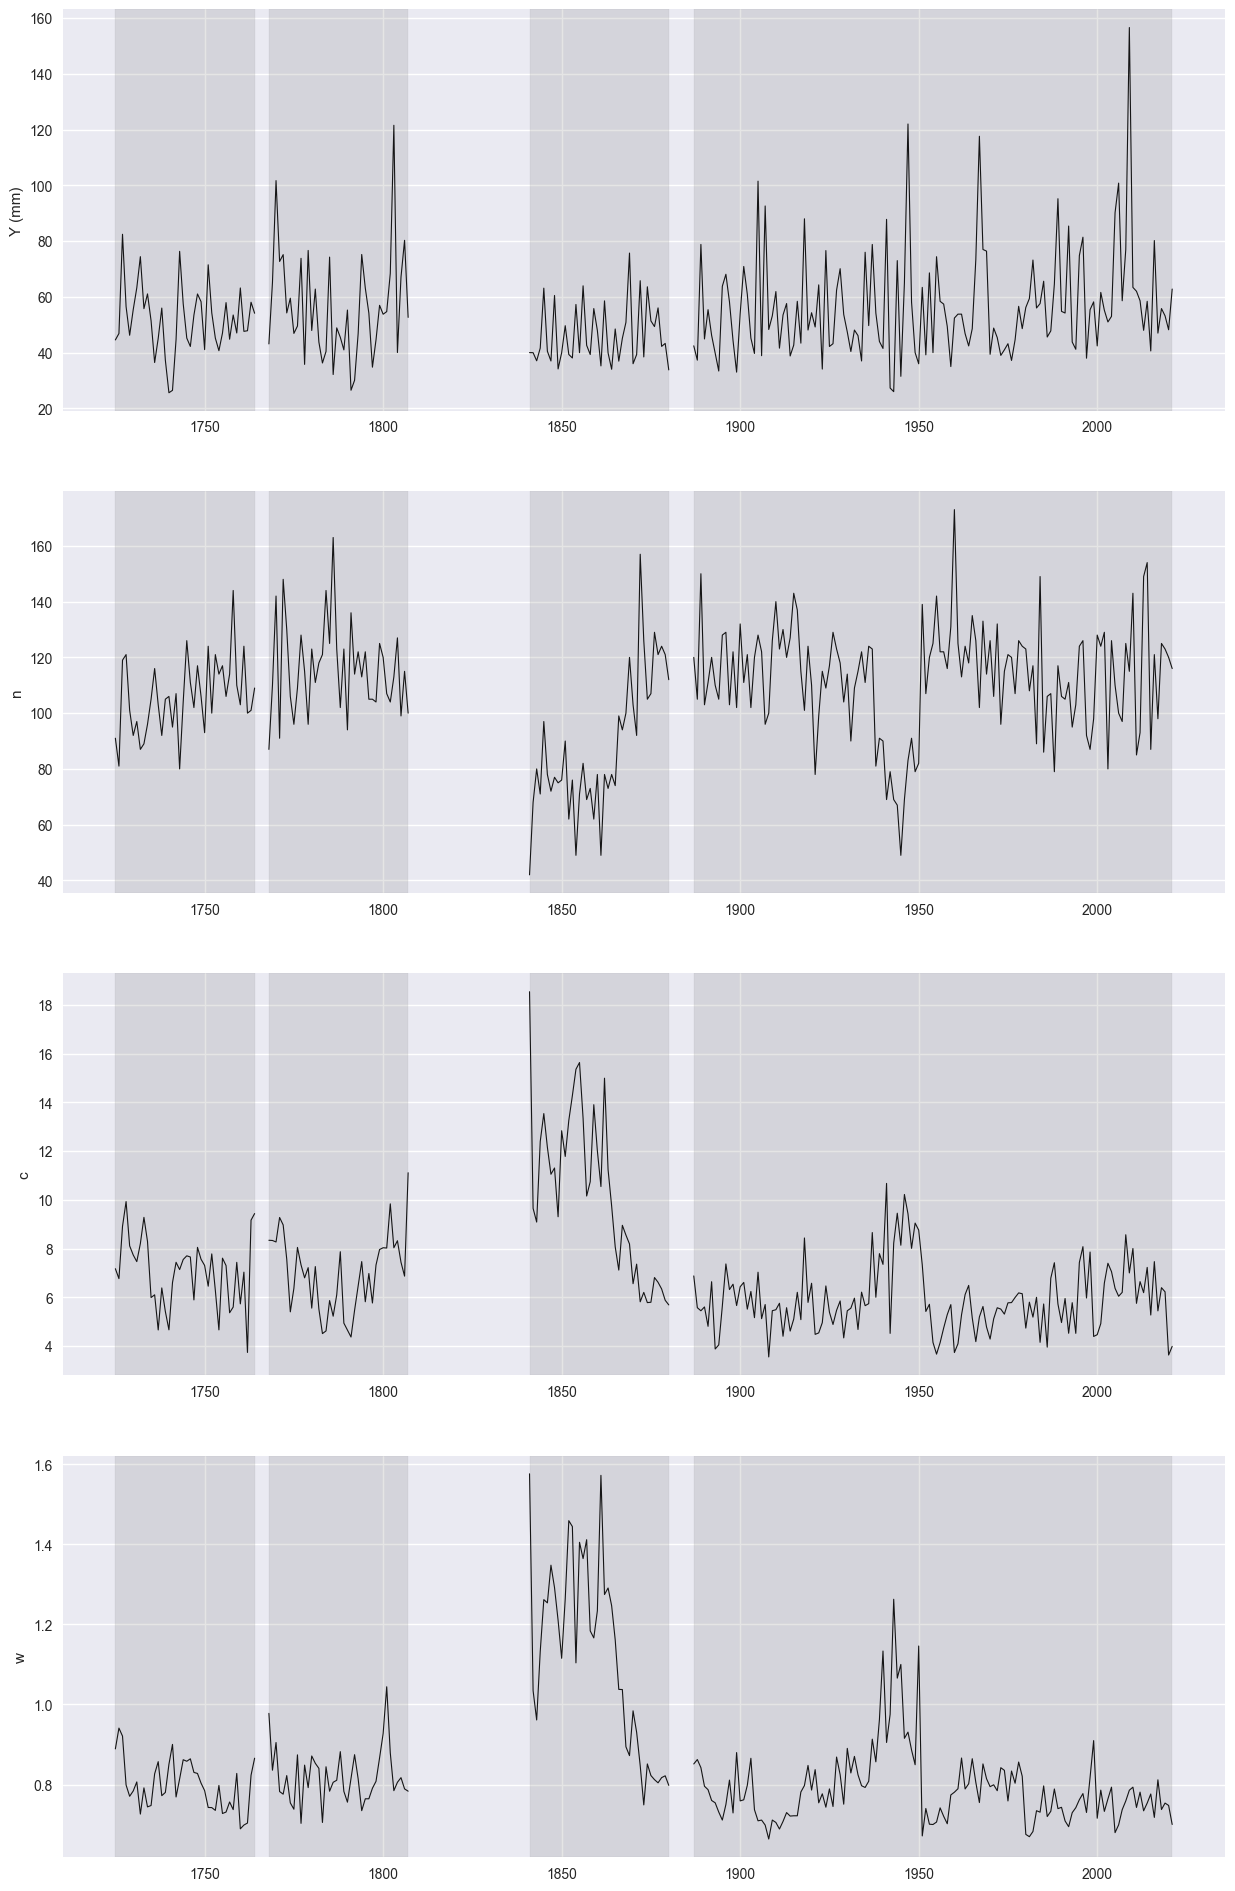

In [16]:
fig, axs = plt.subplots(4, figsize=(15, 24))

# Plotting precipitation
axs[0].plot(df['YEAR'], df['AM'], alpha=0.9, c='k', linewidth=0.8)
axs[1].plot(df['YEAR'], df['n'], alpha=0.9, c='k', linewidth=0.8)
axs[2].plot(df['YEAR'], df['c'], alpha=0.9, c='k', linewidth=0.8)
axs[3].plot(df['YEAR'], df['w'], alpha=0.9, c='k', linewidth=0.8)

# Styling the axis
axs[0].set_ylabel('Y (mm)')
axs[1].set_ylabel('n')
axs[2].set_ylabel('c')
axs[3].set_ylabel('w')

# Study period (Marani, 2015)
for ax in axs:
    ax.axvspan(1725, 1764, color='grey', alpha=0.2)
    ax.axvspan(1768, 1807, color='grey', alpha=0.2)
    ax.axvspan(1841, 1880, color='grey', alpha=0.2)
    ax.axvspan(1887, 2021, color='grey', alpha=0.2)